In [1]:
import netCDF4 as nc
import metpy
import cartopy.crs as ccrs 
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import wrf
from wrf import vinterp, to_np, getvar, CoordPair, vertcross, get_cartopy, latlon_coords, interplevel
import pandas as pd
import matplotlib.ticker as ticker
import os
from metpy.units import units 
import metpy.calc as mpcalc
import xarray as xr
from matplotlib.colors import Normalize
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcolors

C:\Users\Tony\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [97]:
def lfc_cross(lfc_array, ncfile):
    lfc = np.load(lfc_array)
    ncfile = nc.Dataset(ncfile)

    time_part_with_ext = lfc_array.split("\\")[-1].split("_")[-1]
    time_part = time_part_with_ext.replace(".npy", "")
    t = getvar(ncfile, "temp", units='k') * units.kelvin
    td = getvar(ncfile, "td", units='k') * units.kelvin
    p = getvar(ncfile, "pressure") * units.hPa
    z = getvar(ncfile, "z", units='m') * units.meter
    theta = getvar(ncfile, "theta", units="K")
    time = wrf.extract_times(ncfile, timeidx=0)
    time = pd.to_datetime(str(time))
    p_sliced = p[0:25, :, :]
    t_sliced = t[0:25, :, :]
    td_sliced = td[0:25, :, :]
    z_sliced = z[0:25, :, :]
    theta_sliced = theta[0:25, :, :]

    time_part_int = int(time_part)
    hours = time_part_int // 100
    minutes = time_part_int % 100
    time = time.replace(hour=hours, minute=minutes)

    lfc_da = xr.DataArray(lfc, dims=['top_bottom', 'north_south', 'east_west'])

    start_point = CoordPair(lat=46, lon=-90)
    end_point = CoordPair(lat=44.75, lon=-84.5)

    theta_cross = vertcross(theta_sliced, p_sliced, wrfin=ncfile, start_point=start_point,
                        end_point=end_point, latlon=True, meta=True)
    coord_pairs = to_np(theta_cross.coords["xy_loc"])
        
    lfc_cross = vertcross(lfc_da, p_sliced, wrfin=ncfile, start_point=start_point,
                        end_point=end_point, latlon=True, meta=True)
        
    fig, ax = plt.subplots(figsize=(12, 6))

    levels = [1001, 975, 950, 925, 900, 850, 800, 750, 700, 650, 600, 550, 500, 400][::-1]

    theta_contours = ax.contourf(np.arange(coord_pairs.shape[0]),to_np(lfc_cross["vertical"]),
                                    to_np(lfc_cross),cmap='Greens', levels=levels, extend='both')
    cb_theta = fig.colorbar(theta_contours, ax=ax, label='hPa')
    theta_contours = ax.contour(np.arange(coord_pairs.shape[0]),to_np(lfc_cross["vertical"]),
                                    to_np(lfc_cross),colors='black',linestlyes='solid', levels=levels)
    plt.clabel(theta_contours, inline=1, fontsize=12, fmt="%i")
    cb_theta.ax.tick_params(labelsize=5)
    ax.set_ylabel('Pressure (hPa)')
    ax.set_xlabel('Latitude/Longitude')
    x_labels = []
    x_ticks = np.arange(coord_pairs.shape[0])
    for pair in to_np(coord_pairs):
        lat, lon = pair.latlon_str().split(',')
        formatted_lat = '{:.2f}'.format(float(lat))
        formatted_lon = '{:.2f}'.format(float(lon))
        x_labels.append(formatted_lat + ', ' + formatted_lon)
    ax.set_xticks(x_ticks[::20])
    ax.set_xticklabels(x_labels[::20], rotation=45, fontsize=8)
    ax.set_ylim(700, 1000)
    ax.invert_yaxis()
    formatter = ticker.FuncFormatter(lambda x, pos: '{:.0f}'.format(x))
    ax.yaxis.set_major_formatter(formatter)
    ax.grid(axis='y', linestyle='-', linewidth=0.5, color='black')

    plt.title("WRF LFC Cross-Section Between (46, 90) and (44.75, 84.5) at {} UTC".format(time.strftime("%Y-%m-%d %H:%M")))
    plt.savefig('WRF_LFC_Cross{}'.format(time.strftime("%Y-%m-%d-%H_%M")),dpi=450, bbox_inches='tight')
    plt.show()

def lfc_crossZ(lfc_array, ncfile):
    lfc = np.load(lfc_array)
    ncfile = nc.Dataset(ncfile)

    time_part_with_ext = lfc_array.split("\\")[-1].split("_")[-1]
    time_part = time_part_with_ext.replace(".npy", "")
    t = getvar(ncfile, "temp", units='k') * units.kelvin
    td = getvar(ncfile, "td", units='k') * units.kelvin
    p = getvar(ncfile, "pressure") * units.hPa
    z = getvar(ncfile, "z", units='m') * units.meter
    theta = getvar(ncfile, "theta", units="K")
    time = wrf.extract_times(ncfile, timeidx=0)
    time = pd.to_datetime(str(time))
    p_sliced = p[0:25, :, :]
    t_sliced = t[0:25, :, :]
    td_sliced = td[0:25, :, :]
    z_sliced = z[0:25, :, :]
    theta_sliced = theta[0:25, :, :]

    time_part_int = int(time_part)
    hours = time_part_int // 100
    minutes = time_part_int % 100
    time = time.replace(hour=hours, minute=minutes)

    lfc_da = xr.DataArray(lfc, dims=['top_bottom', 'north_south', 'east_west'])

    start_point = CoordPair(lat=46, lon=-90)
    end_point = CoordPair(lat=44.75, lon=-84.5)

    theta_cross = vertcross(theta_sliced, z_sliced, wrfin=ncfile, start_point=start_point,
                        end_point=end_point, latlon=True, meta=True)
    coord_pairs = to_np(theta_cross.coords["xy_loc"])
        
    lfc_cross = vertcross(metpy.calc.pressure_to_height_std(lfc_da*units.hPa)*1000, z_sliced, wrfin=ncfile, start_point=start_point,
                        end_point=end_point, latlon=True, meta=True)
        
    fig, ax = plt.subplots(figsize=(12, 6))

    levels = [500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000, 1100, 1200, 1300, 1400, 1500, 1750, 2000, 2250, 2500, 2750, 3000, 3500, 4000]
    norm = Normalize(vmin=min(levels), vmax=max(levels))


    theta_contours = ax.contourf(np.arange(coord_pairs.shape[0]),to_np(lfc_cross["vertical"]),
                                    to_np(lfc_cross),cmap='YlGn_r', levels=levels, norm=norm)
    cb_theta = fig.colorbar(theta_contours, ax=ax, label='Meters')
    theta_contours = ax.contour(np.arange(coord_pairs.shape[0]),to_np(lfc_cross["vertical"]),
                                    to_np(lfc_cross),colors='black',linestlyes='solid', levels=levels)
    plt.clabel(theta_contours, inline=1, fontsize=12, fmt="%i")
    cb_theta.ax.tick_params(labelsize=5)
    ax.set_ylabel('Altitude AGL (m)')
    ax.set_xlabel('Latitude/Longitude')
    x_labels = []
    x_ticks = np.arange(coord_pairs.shape[0])
    for pair in to_np(coord_pairs):
        lat, lon = pair.latlon_str().split(',')
        formatted_lat = '{:.2f}'.format(float(lat))
        formatted_lon = '{:.2f}'.format(float(lon))
        x_labels.append(formatted_lat + ', ' + formatted_lon)
    ax.set_xticks(x_ticks[::20])
    ax.set_xticklabels(x_labels[::20], rotation=45, fontsize=8)
    ax.set_ylim(0, 3000)
    formatter = ticker.FuncFormatter(lambda x, pos: '{:.0f}'.format(x))
    ax.yaxis.set_major_formatter(formatter)
    ax.grid(axis='y', linestyle='-', linewidth=0.5, color='black')

    plt.title("WRF LFC Cross-Section Between (46, 90) and (44.75, 84.5) at {} UTC".format(time.strftime("%Y-%m-%d %H:%M")))
    plt.savefig('WRF_LFC_Cross_Z{}'.format(time.strftime("%Y-%m-%d-%H_%M")),dpi=450, bbox_inches='tight')
    plt.show()

def lfc_crossZ(lfc_array, ncfile):
    lfc = np.load(lfc_array)
    ncfile = nc.Dataset(ncfile)

    time_part_with_ext = lfc_array.split("\\")[-1].split("_")[-1]
    time_part = time_part_with_ext.replace(".npy", "")
    t = getvar(ncfile, "temp", units='k') * units.kelvin
    td = getvar(ncfile, "td", units='k') * units.kelvin
    p = getvar(ncfile, "pressure") * units.hPa
    z = getvar(ncfile, "z", units='m') * units.meter
    theta = getvar(ncfile, "theta", units="K")
    time = wrf.extract_times(ncfile, timeidx=0)
    time = pd.to_datetime(str(time))
    p_sliced = p[0:25, :, :]
    t_sliced = t[0:25, :, :]
    td_sliced = td[0:25, :, :]
    z_sliced = z[0:25, :, :]
    theta_sliced = theta[0:25, :, :]

    time_part_int = int(time_part)
    hours = time_part_int // 100
    minutes = time_part_int % 100
    time = time.replace(hour=hours, minute=minutes)

    lfc_da = xr.DataArray(lfc, dims=['top_bottom', 'north_south', 'east_west'])

    start_point = CoordPair(lat=46, lon=-90)
    end_point = CoordPair(lat=44.75, lon=-84.5)

    theta_cross = vertcross(theta_sliced, z_sliced, wrfin=ncfile, start_point=start_point,
                        end_point=end_point, latlon=True, meta=True)
    coord_pairs = to_np(theta_cross.coords["xy_loc"])
        
    lfc_cross = vertcross(metpy.calc.pressure_to_height_std(lfc_da*units.hPa)*1000, z_sliced, wrfin=ncfile, start_point=start_point,
                        end_point=end_point, latlon=True, meta=True)
        
    fig, ax = plt.subplots(figsize=(12, 6))

    levels = [500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000, 1100, 1200, 1300, 1400, 1500, 1750, 2000, 2250, 2500, 2750, 3000, 3500, 4000, 4500, 5000]
    levels = [1000, 1050, 1100, 1150, 1200, 1250, 1300, 1350, 1400, 1450, 1500, 1750, 2000, 2250, 2500, 2750, 3000, 3500, 4000, 4500, 5000]
    colors = ["darkgreen", "green", "lime", "greenyellow", 'yellowgreen']

    # Create a custom colormap with a normalization
    #cmap = mcolors.LinearSegmentedColormap.from_list("", colors, N=256)
    #colors = [cmap(level / max(levels)) for level in levels]
    #cmap, norm = mcolors.from_levels_and_colors(levels, colors[:-1], N=256)  # Use one less color than levels


    # Create a Normalize object
    norm = mcolors.Normalize(vmin=1000, vmax=5000)

    colors = [(0, 'darkgreen'),
          (0.05, 'green'),
          (0.15, 'lime'),
          (0.30, 'greenyellow'),
          (0.50, 'yellow'),
          (0.75, 'khaki'),
          (1, 'darkkhaki')]
    
    colors = [(0, 'darkgreen'),
          (0.05, 'green'),
          (0.15, 'limegreen'),
          (0.30, 'lime'),
          (0.50, 'greenyellow'),
          (1, 'white')]

    # Create colormap
    cmap = LinearSegmentedColormap.from_list('custom_colormap', colors)

    #print(lfc_cross.min)


    theta_contours = ax.contourf(np.arange(coord_pairs.shape[0]),to_np(lfc_cross["vertical"]),
                                    to_np(lfc_cross),cmap=cmap, levels=levels, norm=norm)
    cb_theta = fig.colorbar(theta_contours, ax=ax, label='Meters')
    theta_contours = ax.contour(np.arange(coord_pairs.shape[0]),to_np(lfc_cross["vertical"]),
                                    to_np(lfc_cross),colors='black',linestlyes='solid', levels=levels)
    plt.clabel(theta_contours, inline=1, fontsize=12, fmt="%i")
    cb_theta.ax.tick_params(labelsize=5)
    ax.set_ylabel('Altitude AGL (m)')
    ax.set_xlabel('Latitude/Longitude')
    x_labels = []
    x_ticks = np.arange(coord_pairs.shape[0])
    for pair in to_np(coord_pairs):
        lat, lon = pair.latlon_str().split(',')
        formatted_lat = '{:.2f}'.format(float(lat))
        formatted_lon = '{:.2f}'.format(float(lon))
        x_labels.append(formatted_lat + ', ' + formatted_lon)
    ax.set_xticks(x_ticks[::20])
    ax.set_xticklabels(x_labels[::20], rotation=45, fontsize=8)
    ax.set_ylim(0, 3000)
    formatter = ticker.FuncFormatter(lambda x, pos: '{:.0f}'.format(x))
    ax.yaxis.set_major_formatter(formatter)
    ax.grid(axis='y', linestyle='-', linewidth=0.5, color='black')

    plt.title("WRF LFC Cross-Section Between (46, 90) and (44.75, 84.5) at {} UTC".format(time.strftime("%Y-%m-%d %H:%M")))
    plt.savefig('WRF_LFC_Cross_Z{}'.format(time.strftime("%Y-%m-%d-%H_%M")),dpi=450, bbox_inches='tight')
    plt.show()

C:\Users\Tony\anaconda3\lib\site-packages\wrf\metadecorators.py:1092: UserWarning: 'latlon' is set to True, but 'field3d' contains no coordinate information
  warnings.warn("'latlon' is set to True, but 'field3d' "
C:\Users\Tony\AppData\Local\Temp\ipykernel_10712\1428351741.py:44: UserWarning: The following kwargs were not used by contour: 'linestlyes'
  theta_contours = ax.contour(np.arange(coord_pairs.shape[0]),to_np(lfc_cross["vertical"]),


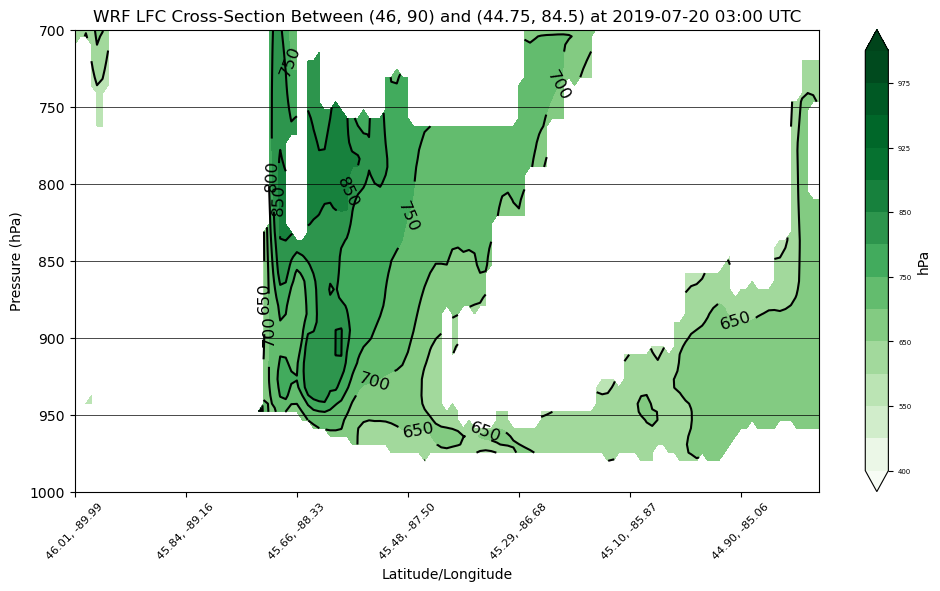

C:\Users\Tony\anaconda3\lib\site-packages\wrf\metadecorators.py:1092: UserWarning: 'latlon' is set to True, but 'field3d' contains no coordinate information
  warnings.warn("'latlon' is set to True, but 'field3d' "
C:\Users\Tony\AppData\Local\Temp\ipykernel_10712\1428351741.py:44: UserWarning: The following kwargs were not used by contour: 'linestlyes'
  theta_contours = ax.contour(np.arange(coord_pairs.shape[0]),to_np(lfc_cross["vertical"]),


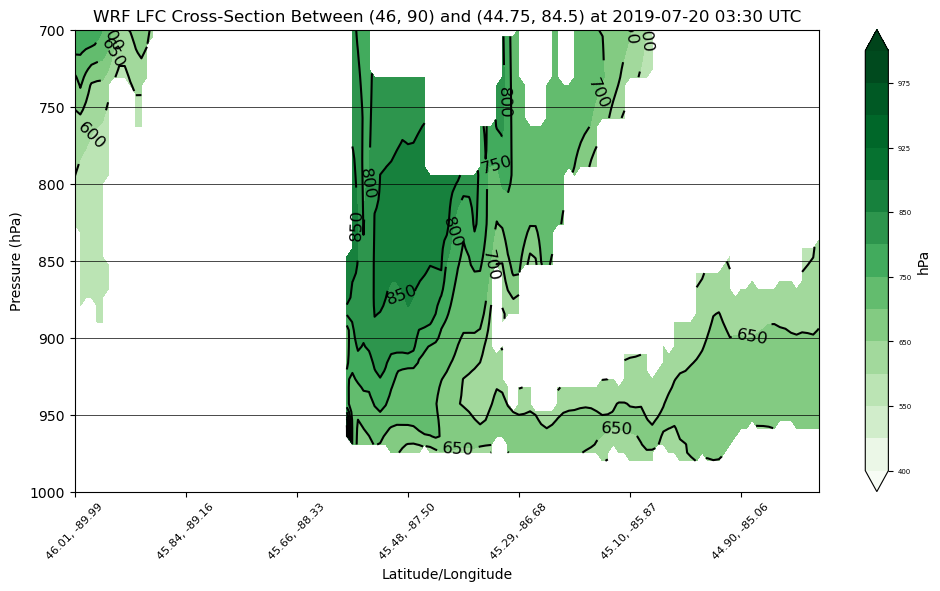

C:\Users\Tony\anaconda3\lib\site-packages\wrf\metadecorators.py:1092: UserWarning: 'latlon' is set to True, but 'field3d' contains no coordinate information
  warnings.warn("'latlon' is set to True, but 'field3d' "
C:\Users\Tony\AppData\Local\Temp\ipykernel_10712\1428351741.py:44: UserWarning: The following kwargs were not used by contour: 'linestlyes'
  theta_contours = ax.contour(np.arange(coord_pairs.shape[0]),to_np(lfc_cross["vertical"]),


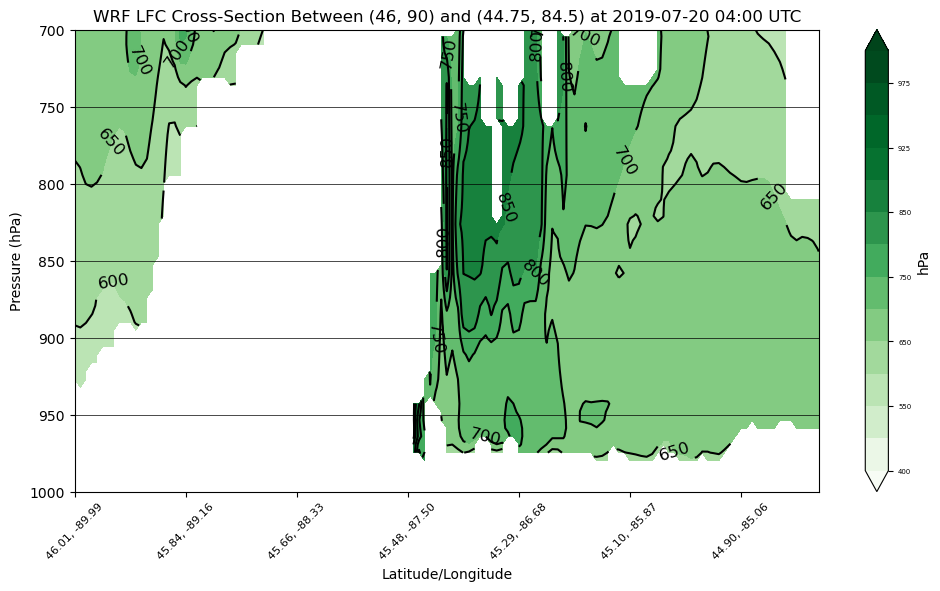

C:\Users\Tony\anaconda3\lib\site-packages\wrf\metadecorators.py:1092: UserWarning: 'latlon' is set to True, but 'field3d' contains no coordinate information
  warnings.warn("'latlon' is set to True, but 'field3d' "
C:\Users\Tony\AppData\Local\Temp\ipykernel_10712\1428351741.py:44: UserWarning: The following kwargs were not used by contour: 'linestlyes'
  theta_contours = ax.contour(np.arange(coord_pairs.shape[0]),to_np(lfc_cross["vertical"]),


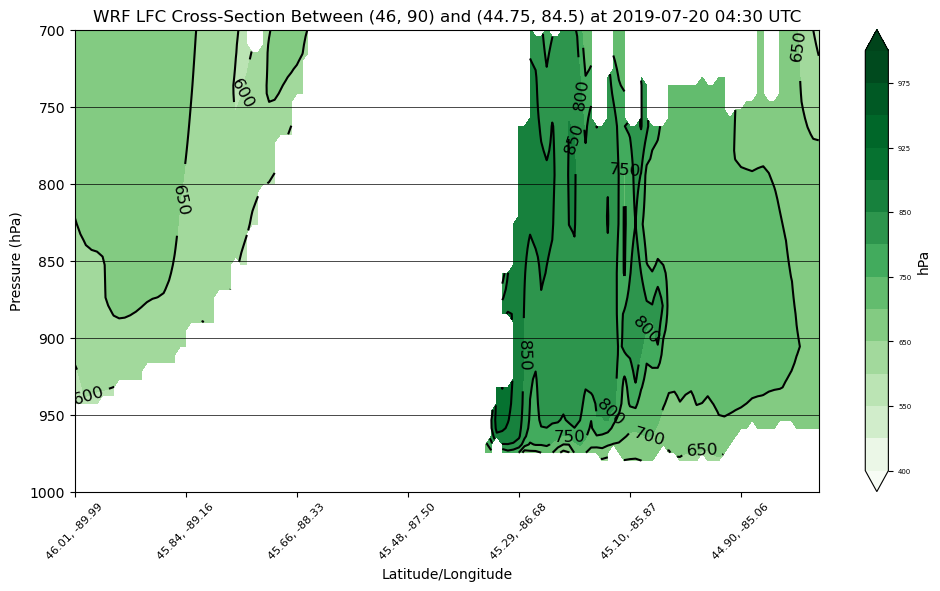

C:\Users\Tony\anaconda3\lib\site-packages\wrf\metadecorators.py:1092: UserWarning: 'latlon' is set to True, but 'field3d' contains no coordinate information
  warnings.warn("'latlon' is set to True, but 'field3d' "
C:\Users\Tony\AppData\Local\Temp\ipykernel_10712\1428351741.py:44: UserWarning: The following kwargs were not used by contour: 'linestlyes'
  theta_contours = ax.contour(np.arange(coord_pairs.shape[0]),to_np(lfc_cross["vertical"]),


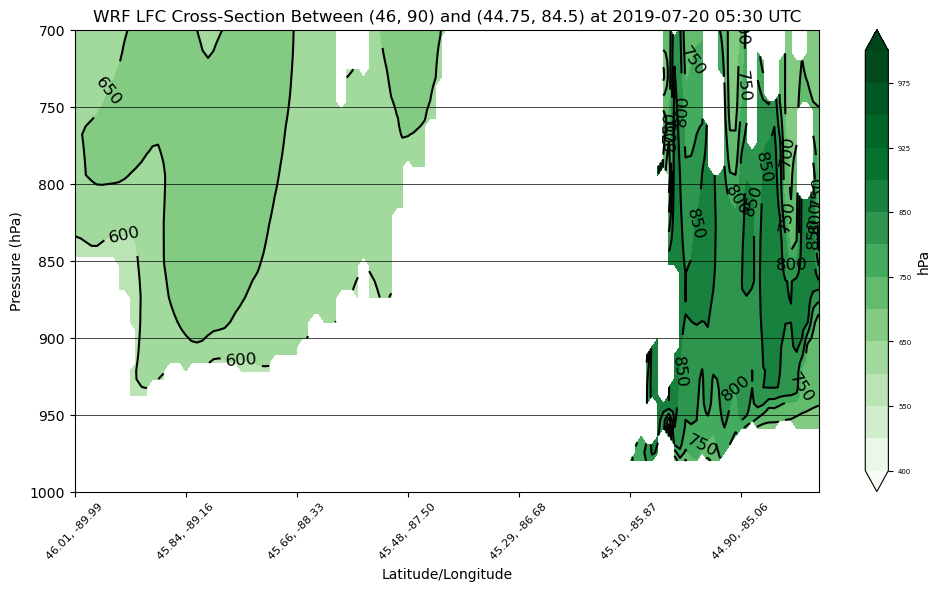

C:\Users\Tony\anaconda3\lib\site-packages\wrf\metadecorators.py:1092: UserWarning: 'latlon' is set to True, but 'field3d' contains no coordinate information
  warnings.warn("'latlon' is set to True, but 'field3d' "
C:\Users\Tony\AppData\Local\Temp\ipykernel_10712\1428351741.py:44: UserWarning: The following kwargs were not used by contour: 'linestlyes'
  theta_contours = ax.contour(np.arange(coord_pairs.shape[0]),to_np(lfc_cross["vertical"]),


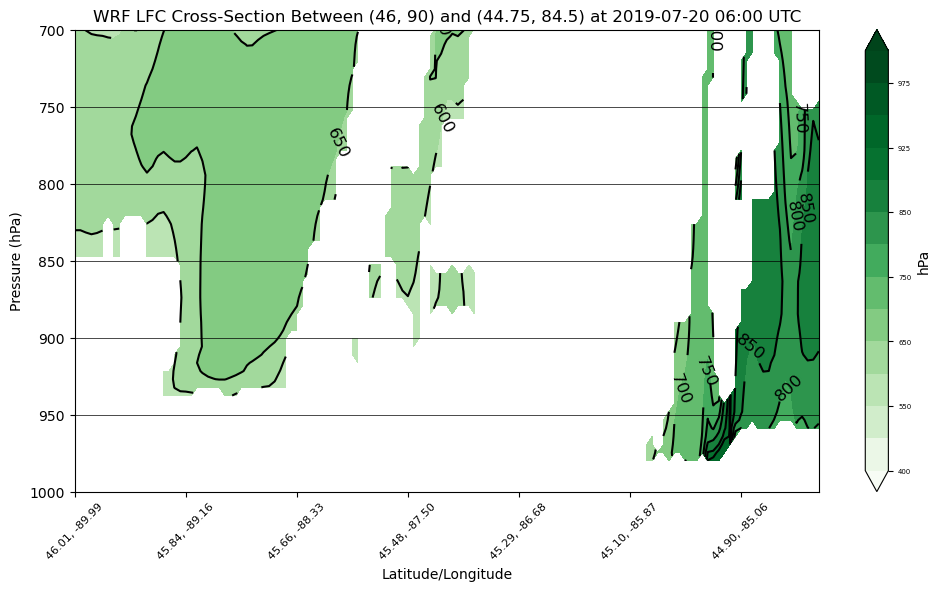

In [7]:
directory = 'C:\\Users\\Tony\\Desktop\\wrfoutput\\lfcs'
ncfile = 'C:\\Users\\Tony\\Desktop\\wrfoutput\\lots of levels\\wrfout_d02_2019-07-20_00_00_00'
for filename in os.listdir(directory):
    file_path = os.path.join(directory, filename)
    lfc_cross(file_path, ncfile)

C:\Users\Tony\anaconda3\lib\site-packages\wrf\metadecorators.py:1092: UserWarning: 'latlon' is set to True, but 'field3d' contains no coordinate information
  warnings.warn("'latlon' is set to True, but 'field3d' "
C:\Users\Tony\AppData\Local\Temp\ipykernel_10712\2409732131.py:213: UserWarning: The following kwargs were not used by contour: 'linestlyes'
  theta_contours = ax.contour(np.arange(coord_pairs.shape[0]),to_np(lfc_cross["vertical"]),


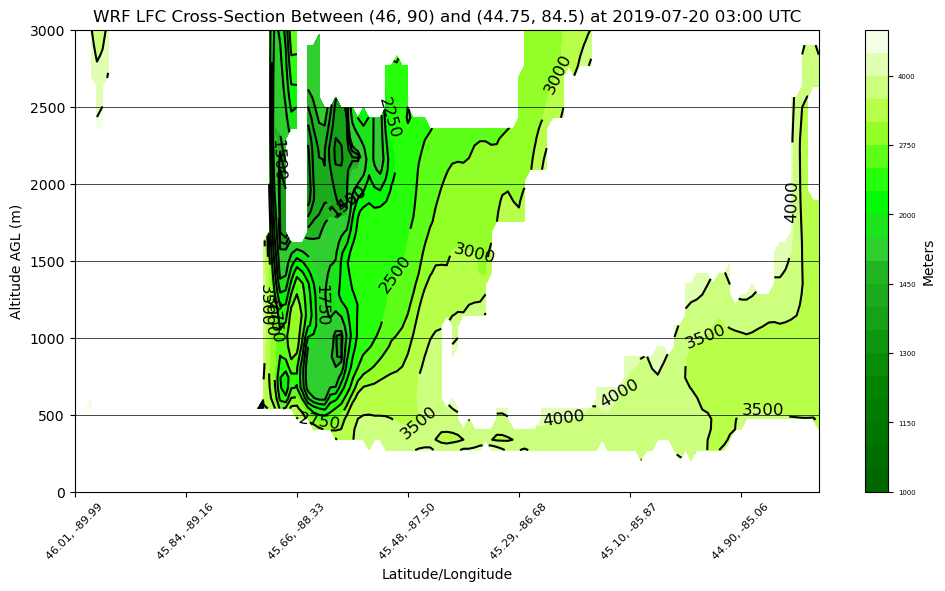

C:\Users\Tony\anaconda3\lib\site-packages\wrf\metadecorators.py:1092: UserWarning: 'latlon' is set to True, but 'field3d' contains no coordinate information
  warnings.warn("'latlon' is set to True, but 'field3d' "
C:\Users\Tony\AppData\Local\Temp\ipykernel_10712\2409732131.py:213: UserWarning: The following kwargs were not used by contour: 'linestlyes'
  theta_contours = ax.contour(np.arange(coord_pairs.shape[0]),to_np(lfc_cross["vertical"]),


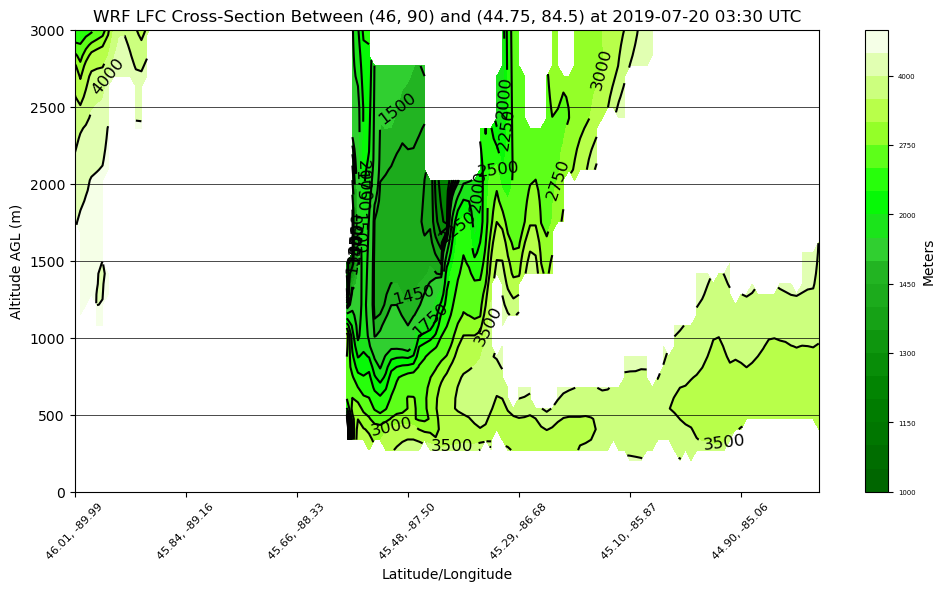

C:\Users\Tony\anaconda3\lib\site-packages\wrf\metadecorators.py:1092: UserWarning: 'latlon' is set to True, but 'field3d' contains no coordinate information
  warnings.warn("'latlon' is set to True, but 'field3d' "
C:\Users\Tony\AppData\Local\Temp\ipykernel_10712\2409732131.py:213: UserWarning: The following kwargs were not used by contour: 'linestlyes'
  theta_contours = ax.contour(np.arange(coord_pairs.shape[0]),to_np(lfc_cross["vertical"]),


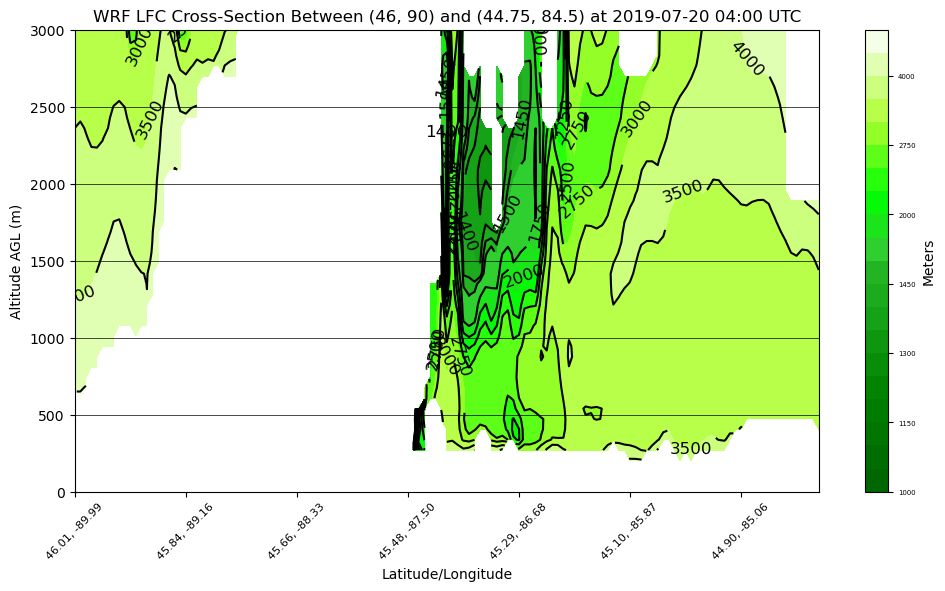

C:\Users\Tony\anaconda3\lib\site-packages\wrf\metadecorators.py:1092: UserWarning: 'latlon' is set to True, but 'field3d' contains no coordinate information
  warnings.warn("'latlon' is set to True, but 'field3d' "
C:\Users\Tony\AppData\Local\Temp\ipykernel_10712\2409732131.py:213: UserWarning: The following kwargs were not used by contour: 'linestlyes'
  theta_contours = ax.contour(np.arange(coord_pairs.shape[0]),to_np(lfc_cross["vertical"]),


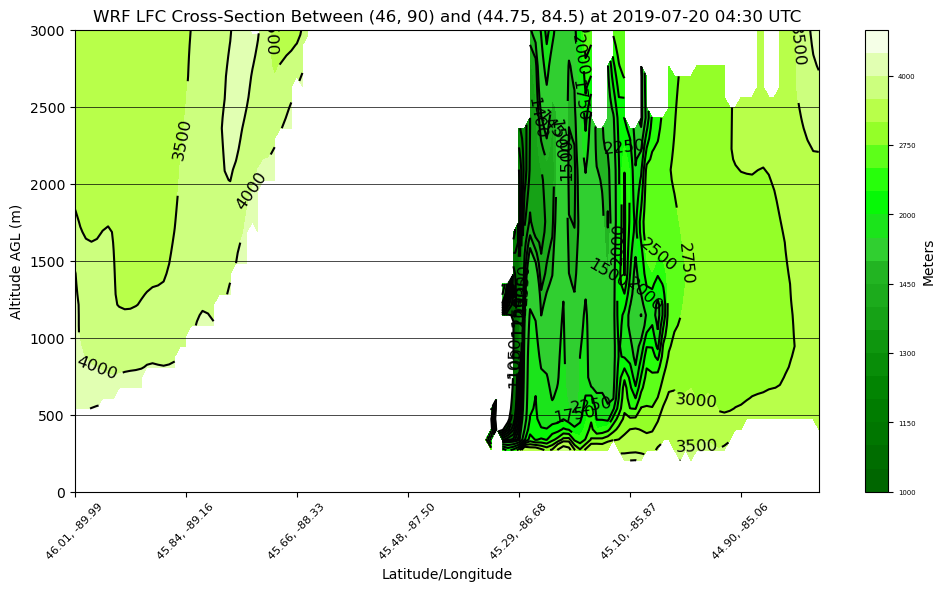

C:\Users\Tony\anaconda3\lib\site-packages\wrf\metadecorators.py:1092: UserWarning: 'latlon' is set to True, but 'field3d' contains no coordinate information
  warnings.warn("'latlon' is set to True, but 'field3d' "
C:\Users\Tony\AppData\Local\Temp\ipykernel_10712\2409732131.py:213: UserWarning: The following kwargs were not used by contour: 'linestlyes'
  theta_contours = ax.contour(np.arange(coord_pairs.shape[0]),to_np(lfc_cross["vertical"]),


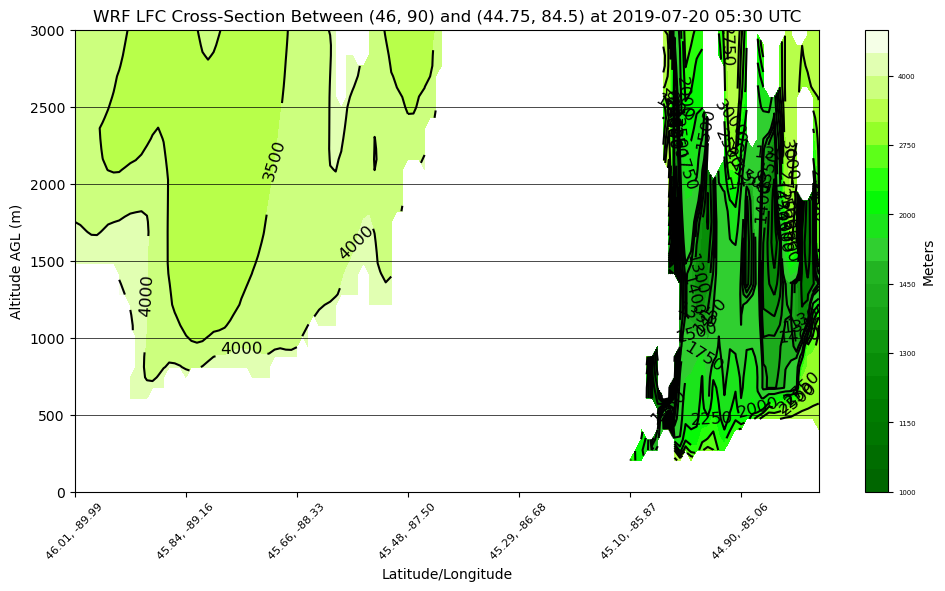

C:\Users\Tony\anaconda3\lib\site-packages\wrf\metadecorators.py:1092: UserWarning: 'latlon' is set to True, but 'field3d' contains no coordinate information
  warnings.warn("'latlon' is set to True, but 'field3d' "
C:\Users\Tony\AppData\Local\Temp\ipykernel_10712\2409732131.py:213: UserWarning: The following kwargs were not used by contour: 'linestlyes'
  theta_contours = ax.contour(np.arange(coord_pairs.shape[0]),to_np(lfc_cross["vertical"]),


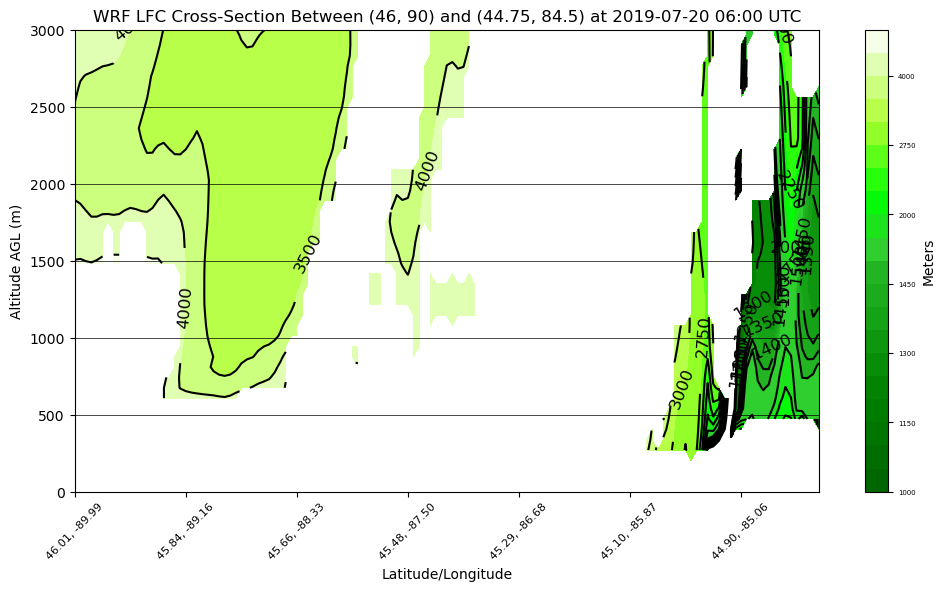

In [98]:
directory = 'C:\\Users\\Tony\\Desktop\\wrfoutput\\lfcs'
ncfile = 'C:\\Users\\Tony\\Desktop\\wrfoutput\\lots of levels\\wrfout_d02_2019-07-20_00_00_00'
for filename in os.listdir(directory):
    file_path = os.path.join(directory, filename)
    lfc_crossZ(file_path, ncfile)

In [4]:
def lfc_crossZ(lfc_array, ncfile):
    lfc = np.load(lfc_array)
    ncfile = nc.Dataset(ncfile)

    time_part_with_ext = lfc_array.split("\\")[-1].split("_")[-1]
    time_part = time_part_with_ext.replace(".npy", "")
    t = getvar(ncfile, "temp", units='k') * units.kelvin
    td = getvar(ncfile, "td", units='k') * units.kelvin
    p = getvar(ncfile, "pressure") * units.hPa
    z = getvar(ncfile, "z", units='m') * units.meter
    theta = getvar(ncfile, "theta", units="K")
    time = wrf.extract_times(ncfile, timeidx=0)
    time = pd.to_datetime(str(time))
    p_sliced = p[0:25, :, :]
    t_sliced = t[0:25, :, :]
    td_sliced = td[0:25, :, :]
    z_sliced = z[0:25, :, :]
    theta_sliced = theta[0:25, :, :]
    ref = ncfile.variables["REFL_10CM"]
    ref = ref[0, 0, :, :]  
    ref = np.where(ref < 1, np.nan, ref)

    time_part_int = int(time_part)
    hours = time_part_int // 100
    minutes = time_part_int % 100
    time = time.replace(hour=hours, minute=minutes)

    lfc_da = xr.DataArray(lfc, dims=['top_bottom', 'north_south', 'east_west'])

    start_point = CoordPair(lat=46, lon=-90)
    end_point = CoordPair(lat=44.75, lon=-84.5)

    theta_cross = vertcross(theta_sliced, z_sliced, wrfin=ncfile, start_point=start_point,
                        end_point=end_point, latlon=True, meta=True)
    coord_pairs = to_np(theta_cross.coords["xy_loc"])
        
    lfc_cross = vertcross(metpy.calc.pressure_to_height_std(lfc_da*units.hPa)*1000, z_sliced, wrfin=ncfile, start_point=start_point,
                        end_point=end_point, latlon=True, meta=True)
        
    fig, ax = plt.subplots(figsize=(12, 6))

    levels = [500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000, 1100, 1200, 1300, 1400, 1500, 1750, 2000, 2250, 2500, 2750, 3000, 3500, 4000, 4500, 5000]
    levels = [1000, 1050, 1100, 1150, 1200, 1250, 1300, 1350, 1400, 1450, 1500, 1750, 2000, 2250, 2500, 2750, 3000, 3500, 4000, 4500, 5000]
    levels = [1000, 1250, 1500, 1750, 2000, 2500, 3000, 4000]

    colors = ["darkgreen", "green", "lime", "greenyellow", 'yellowgreen']

    # Create a custom colormap with a normalization
    #cmap = mcolors.LinearSegmentedColormap.from_list("", colors, N=256)
    #colors = [cmap(level / max(levels)) for level in levels]
    #cmap, norm = mcolors.from_levels_and_colors(levels, colors[:-1], N=256)  # Use one less color than levels


    # Create a Normalize object
    norm = mcolors.Normalize(vmin=1000, vmax=5000)

    colors = [(0, 'darkgreen'),
          (0.05, 'green'),
          (0.15, 'lime'),
          (0.30, 'greenyellow'),
          (0.50, 'yellow'),
          (0.75, 'khaki'),
          (1, 'darkkhaki')]
    
    colors = [(0, 'darkgreen'),
          (0.05, 'green'),
          (0.15, 'limegreen'),
          (0.30, 'lime'),
          (0.50, 'greenyellow'),
          (1, 'white')]

    # Create colormap
    cmap = 'gist_rainbow_r'

    #print(lfc_cross.min)


    theta_contours = ax.contourf(np.arange(coord_pairs.shape[0]),to_np(lfc_cross["vertical"]),
                                    to_np(lfc_cross),cmap=cmap, levels=levels, norm=norm)
    cb_theta = fig.colorbar(theta_contours, ax=ax, label='Meters')
    theta_contours = ax.contour(np.arange(coord_pairs.shape[0]),to_np(lfc_cross["vertical"]),
                                    to_np(lfc_cross),colors='black',linestlyes='solid', levels=levels)
    plt.clabel(theta_contours, inline=1, fontsize=12, fmt="%i")
    cb_theta.ax.tick_params(labelsize=5)
    ax.set_ylabel('Altitude (m)')
    ax.set_xlabel('Latitude/Longitude')
    x_labels = []
    x_ticks = np.arange(coord_pairs.shape[0])
    for pair in to_np(coord_pairs):
        lat, lon = pair.latlon_str().split(',')
        formatted_lat = '{:.2f}'.format(float(lat))
        formatted_lon = '{:.2f}'.format(float(lon))
        x_labels.append(formatted_lat + ', ' + formatted_lon)
    ax.set_xticks(x_ticks[::20])
    ax.set_xticklabels(x_labels[::20], rotation=45, fontsize=8)
    ax.set_ylim(0, 4000)
    formatter = ticker.FuncFormatter(lambda x, pos: '{:.0f}'.format(x))
    ax.yaxis.set_major_formatter(formatter)
    ax.grid(axis='y', linestyle='-', linewidth=0.5, color='black')
    

    plt.title("WRF LFC Cross-Section Between (46, 90) and (44.75, 84.5) at {} UTC".format(time.strftime("%Y-%m-%d %H:%M")))
    plt.savefig('NEWWRF_LFC_Cross_Z{}'.format(time.strftime("%Y-%m-%d-%H_%M")),dpi=450, bbox_inches='tight')
    plt.show()

C:\Users\Tony\anaconda3\lib\site-packages\wrf\metadecorators.py:1092: UserWarning: 'latlon' is set to True, but 'field3d' contains no coordinate information
  warnings.warn("'latlon' is set to True, but 'field3d' "
C:\Users\Tony\AppData\Local\Temp\ipykernel_15136\2109314320.py:81: UserWarning: The following kwargs were not used by contour: 'linestlyes'
  theta_contours = ax.contour(np.arange(coord_pairs.shape[0]),to_np(lfc_cross["vertical"]),


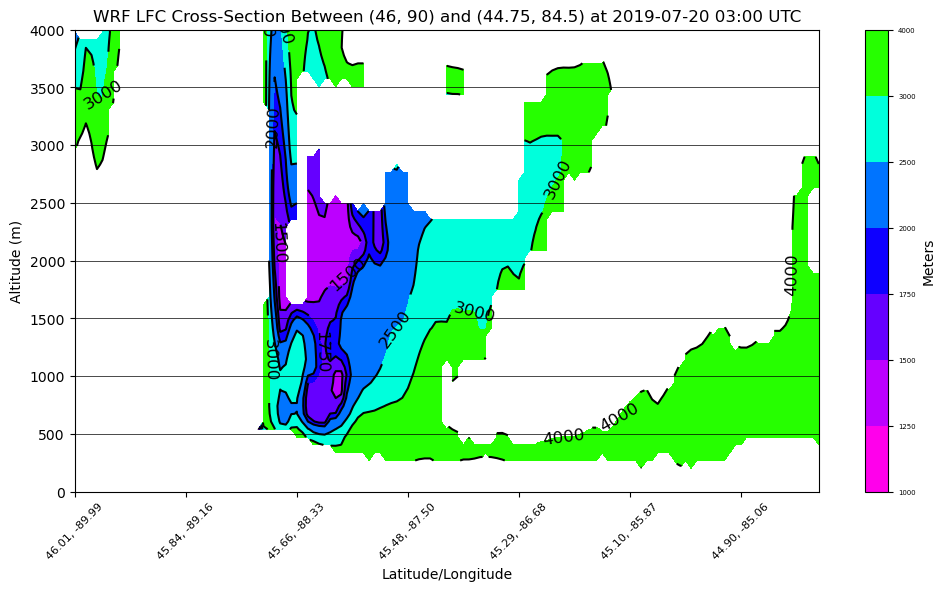

C:\Users\Tony\anaconda3\lib\site-packages\wrf\metadecorators.py:1092: UserWarning: 'latlon' is set to True, but 'field3d' contains no coordinate information
  warnings.warn("'latlon' is set to True, but 'field3d' "
C:\Users\Tony\AppData\Local\Temp\ipykernel_15136\2109314320.py:81: UserWarning: The following kwargs were not used by contour: 'linestlyes'
  theta_contours = ax.contour(np.arange(coord_pairs.shape[0]),to_np(lfc_cross["vertical"]),


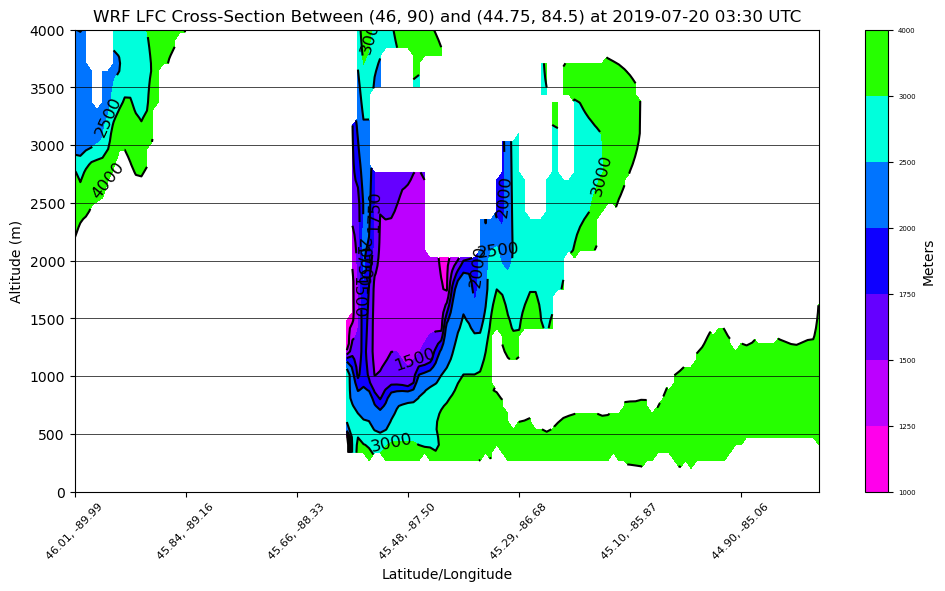

C:\Users\Tony\anaconda3\lib\site-packages\wrf\metadecorators.py:1092: UserWarning: 'latlon' is set to True, but 'field3d' contains no coordinate information
  warnings.warn("'latlon' is set to True, but 'field3d' "
C:\Users\Tony\AppData\Local\Temp\ipykernel_15136\2109314320.py:81: UserWarning: The following kwargs were not used by contour: 'linestlyes'
  theta_contours = ax.contour(np.arange(coord_pairs.shape[0]),to_np(lfc_cross["vertical"]),


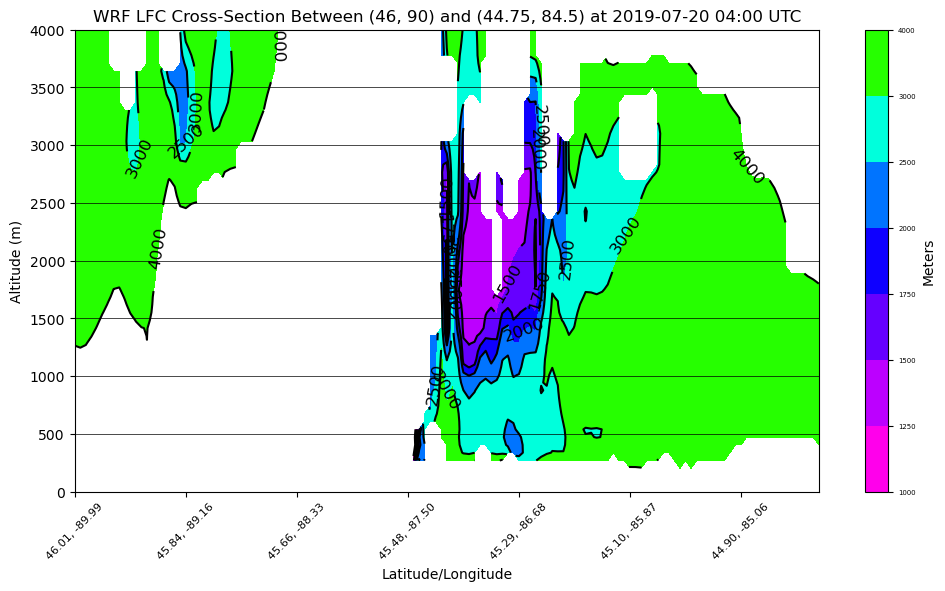

C:\Users\Tony\anaconda3\lib\site-packages\wrf\metadecorators.py:1092: UserWarning: 'latlon' is set to True, but 'field3d' contains no coordinate information
  warnings.warn("'latlon' is set to True, but 'field3d' "
C:\Users\Tony\AppData\Local\Temp\ipykernel_15136\2109314320.py:81: UserWarning: The following kwargs were not used by contour: 'linestlyes'
  theta_contours = ax.contour(np.arange(coord_pairs.shape[0]),to_np(lfc_cross["vertical"]),


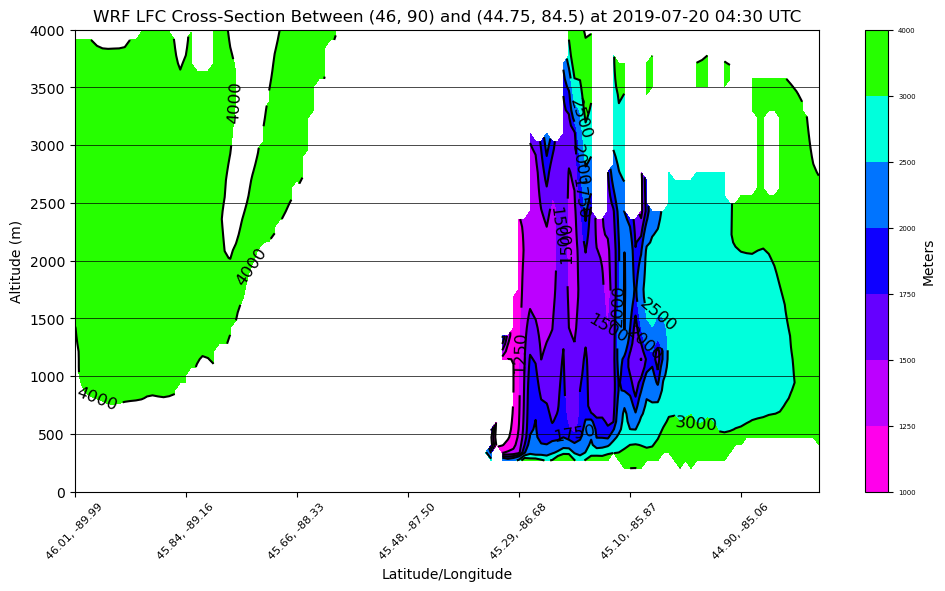

C:\Users\Tony\anaconda3\lib\site-packages\wrf\metadecorators.py:1092: UserWarning: 'latlon' is set to True, but 'field3d' contains no coordinate information
  warnings.warn("'latlon' is set to True, but 'field3d' "
C:\Users\Tony\AppData\Local\Temp\ipykernel_15136\2109314320.py:81: UserWarning: The following kwargs were not used by contour: 'linestlyes'
  theta_contours = ax.contour(np.arange(coord_pairs.shape[0]),to_np(lfc_cross["vertical"]),


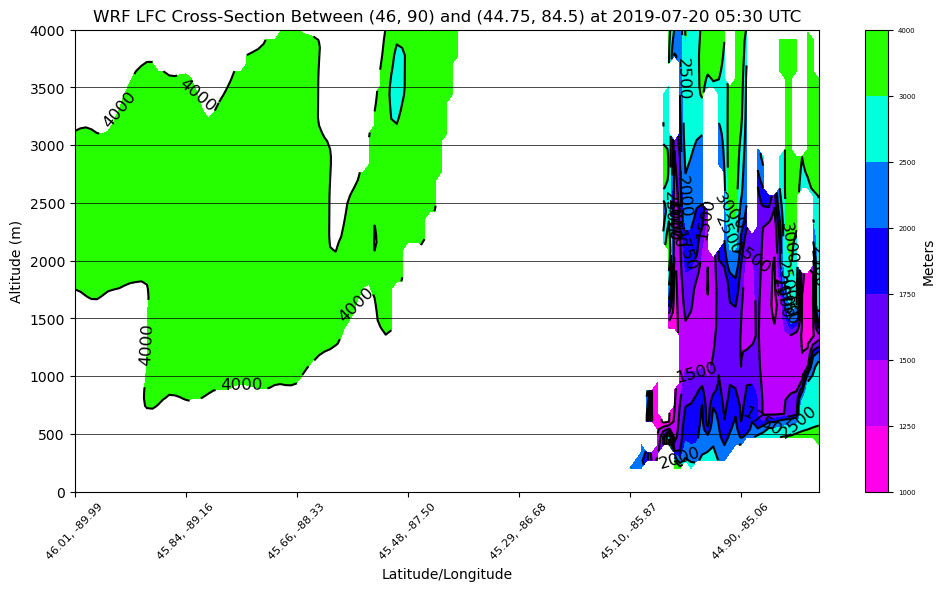

C:\Users\Tony\anaconda3\lib\site-packages\wrf\metadecorators.py:1092: UserWarning: 'latlon' is set to True, but 'field3d' contains no coordinate information
  warnings.warn("'latlon' is set to True, but 'field3d' "
C:\Users\Tony\AppData\Local\Temp\ipykernel_15136\2109314320.py:81: UserWarning: The following kwargs were not used by contour: 'linestlyes'
  theta_contours = ax.contour(np.arange(coord_pairs.shape[0]),to_np(lfc_cross["vertical"]),


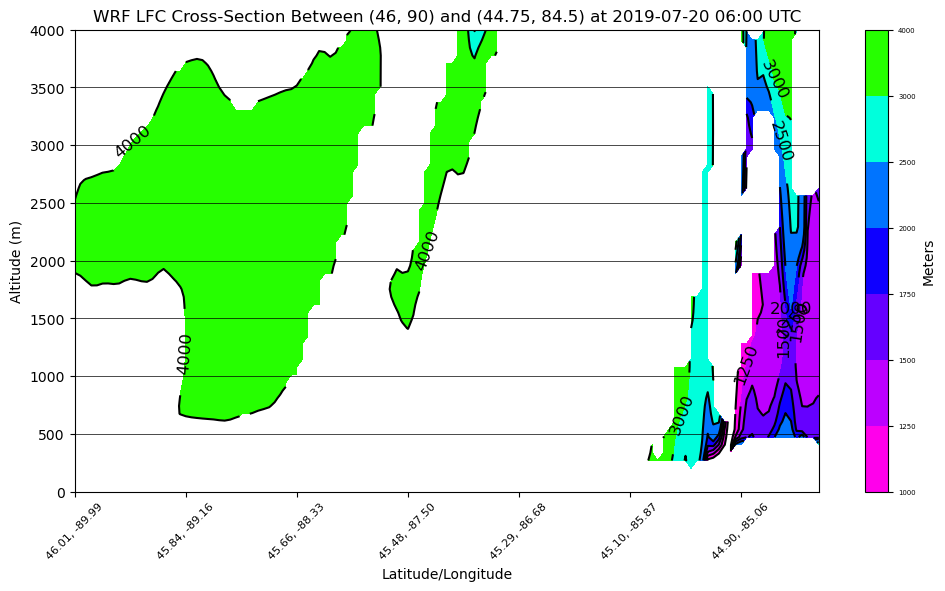

In [5]:
directory = 'C:\\Users\\Tony\\Desktop\\wrfoutput\\lfcs'
ncfile = 'C:\\Users\\Tony\\Desktop\\wrfoutput\\lots of levels\\wrfout_d02_2019-07-20_00_00_00'
for filename in os.listdir(directory):
    file_path = os.path.join(directory, filename)
    lfc_crossZ(file_path, ncfile)

In [107]:
def cape_cross(lfc_array, ncfile):
    lfc = np.load(lfc_array)
    ncfile = nc.Dataset(ncfile)

    time_part_with_ext = lfc_array.split("\\")[-1].split("_")[-1]
    time_part = time_part_with_ext.replace(".npy", "")
    t = getvar(ncfile, "temp", units='k') * units.kelvin
    td = getvar(ncfile, "td", units='k') * units.kelvin
    p = getvar(ncfile, "pressure") * units.hPa
    z = getvar(ncfile, "z", units='m') * units.meter
    theta = getvar(ncfile, "theta", units="K")
    time = wrf.extract_times(ncfile, timeidx=0)
    time = pd.to_datetime(str(time))
    p_sliced = p[0:20, :, :]
    t_sliced = t[0:20, :, :]
    td_sliced = td[0:20, :, :]
    z_sliced = z[0:20, :, :]
    theta_sliced = theta[0:20, :, :]

    #time_part_int = int(time_part)
    #hours = time_part_int // 100
    #minutes = time_part_int % 100
    #time = time.replace(hour=hours, minute=minutes)

    lfc_da = xr.DataArray(lfc, dims=['top_bottom', 'north_south', 'east_west'])

    start_point = CoordPair(lat=46, lon=-90)
    end_point = CoordPair(lat=44.75, lon=-84.5)

    theta_cross = vertcross(theta_sliced, z_sliced, wrfin=ncfile, start_point=start_point,
                        end_point=end_point, latlon=True, meta=True)
    coord_pairs = to_np(theta_cross.coords["xy_loc"])
        
    lfc_cross = vertcross(lfc_da, z_sliced, wrfin=ncfile, start_point=start_point,
                        end_point=end_point, latlon=True, meta=True)
        
    fig, ax = plt.subplots(figsize=(12, 6))

    #levels = [1001, 975, 950, 925, 900, 850, 800, 750, 700, 650, 600, 550, 500, 400][::-1]

    theta_contours = ax.contourf(np.arange(coord_pairs.shape[0]),to_np(lfc_cross["vertical"]),
                                    to_np(lfc_cross),cmap='Reds', levels=np.arange(0,4500,500), extend='both')
    cb_theta = fig.colorbar(theta_contours, ax=ax, label='hPa')
    theta_contours = ax.contour(np.arange(coord_pairs.shape[0]),to_np(lfc_cross["vertical"]),
                                    to_np(lfc_cross),colors='black',linestlyes='solid', levels=np.arange(0,4500,500))
    plt.clabel(theta_contours, inline=1, fontsize=12, fmt="%i")
    cb_theta.ax.tick_params(labelsize=5)
    ax.set_ylabel('Pressure (hPa)')
    ax.set_xlabel('Latitude/Longitude')
    x_labels = []
    x_ticks = np.arange(coord_pairs.shape[0])
    for pair in to_np(coord_pairs):
        lat, lon = pair.latlon_str().split(',')
        formatted_lat = '{:.2f}'.format(float(lat))
        formatted_lon = '{:.2f}'.format(float(lon))
        x_labels.append(formatted_lat + ', ' + formatted_lon)
    ax.set_xticks(x_ticks[::20])
    ax.set_xticklabels(x_labels[::20], rotation=45, fontsize=8)
    ax.set_ylim(0, 5000)
    #ax.invert_yaxis()
    formatter = ticker.FuncFormatter(lambda x, pos: '{:.0f}'.format(x))
    ax.yaxis.set_major_formatter(formatter)
    ax.grid(axis='y', linestyle='-', linewidth=0.5, color='black')

    #plt.title("WRF LFC Cross-Section Between (46, 90) and (44.75, 84.5) at {} UTC".format(time.strftime("%Y-%m-%d %H:%M")))
    #plt.savefig('WRF_LFC_Cross{}'.format(time.strftime("%Y-%m-%d-%H_%M")),dpi=450, bbox_inches='tight')
    plt.show()

C:\Users\Tony\anaconda3\lib\site-packages\wrf\metadecorators.py:1092: UserWarning: 'latlon' is set to True, but 'field3d' contains no coordinate information
  warnings.warn("'latlon' is set to True, but 'field3d' "
C:\Users\Tony\AppData\Local\Temp\ipykernel_10712\3633687400.py:44: UserWarning: The following kwargs were not used by contour: 'linestlyes'
  theta_contours = ax.contour(np.arange(coord_pairs.shape[0]),to_np(lfc_cross["vertical"]),


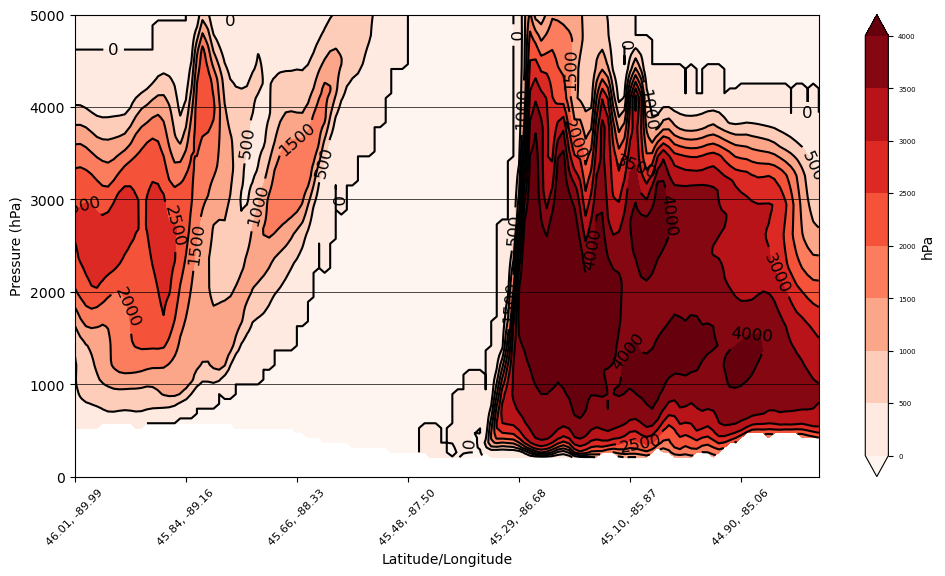

C:\Users\Tony\anaconda3\lib\site-packages\wrf\metadecorators.py:1092: UserWarning: 'latlon' is set to True, but 'field3d' contains no coordinate information
  warnings.warn("'latlon' is set to True, but 'field3d' "
C:\Users\Tony\AppData\Local\Temp\ipykernel_10712\3633687400.py:44: UserWarning: The following kwargs were not used by contour: 'linestlyes'
  theta_contours = ax.contour(np.arange(coord_pairs.shape[0]),to_np(lfc_cross["vertical"]),


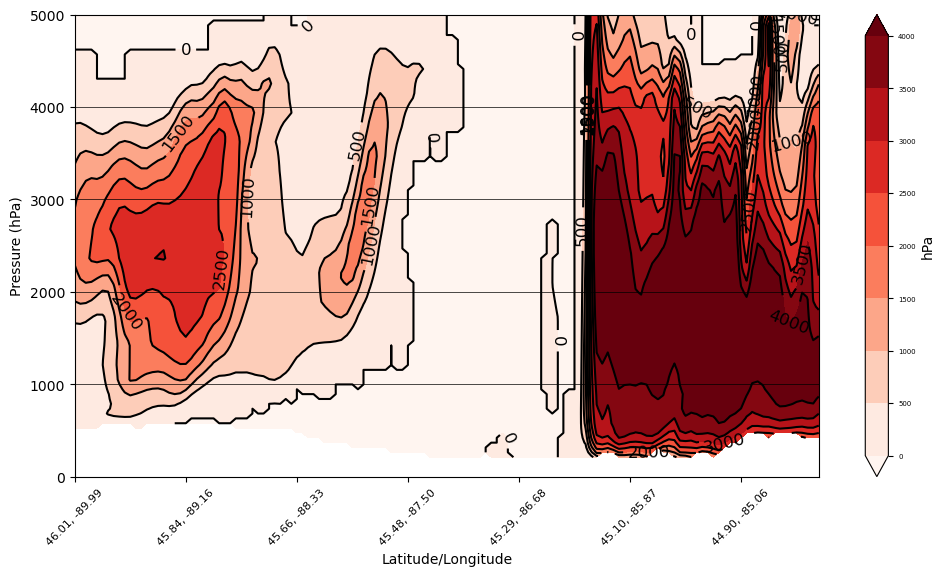

C:\Users\Tony\anaconda3\lib\site-packages\wrf\metadecorators.py:1092: UserWarning: 'latlon' is set to True, but 'field3d' contains no coordinate information
  warnings.warn("'latlon' is set to True, but 'field3d' "
C:\Users\Tony\AppData\Local\Temp\ipykernel_10712\3633687400.py:44: UserWarning: The following kwargs were not used by contour: 'linestlyes'
  theta_contours = ax.contour(np.arange(coord_pairs.shape[0]),to_np(lfc_cross["vertical"]),


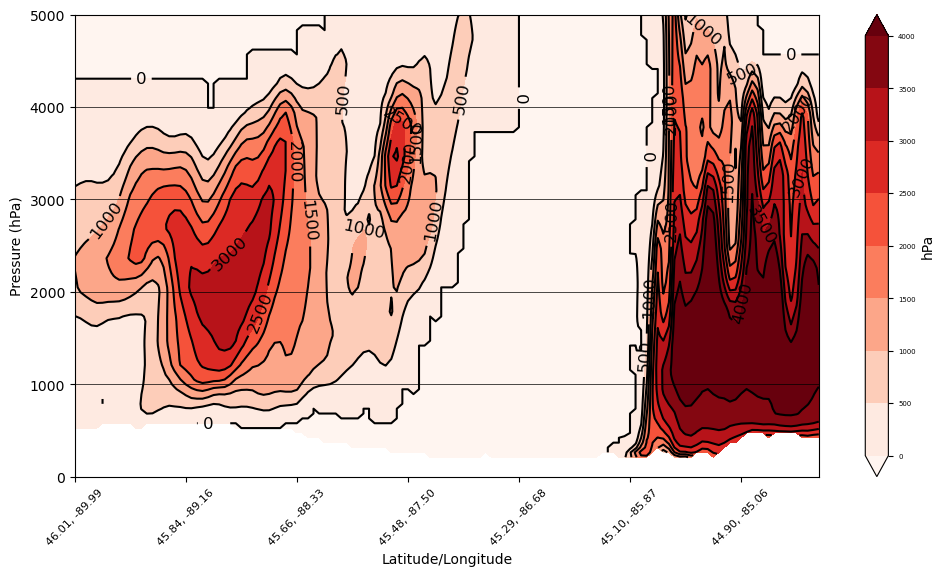

In [108]:
directory = 'C:\\Users\\Tony\\Desktop\\METR 4990\\cape'
ncfile = 'C:\\Users\\Tony\\Desktop\\wrfoutput\\lots of levels\\wrfout_d02_2019-07-20_00_00_00'
for filename in os.listdir(directory):
    file_path = os.path.join(directory, filename)
    cape_cross(file_path, ncfile)